In [1]:
#!pip install transformers
#!pip install tensorflow

import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import time
import datetime
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup


#!pip install transformers
#!pip install wget

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


2022-10-23 11:52:33.052490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 11:52:44.784202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-10-23 11:52:44.784224: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-23 11:52:45.964777: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 11:53:04.4555

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-PCIE-16GB


2022-10-23 11:53:48.197823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 11:53:48.392643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-10-23 11:53:48.393273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-10-23 11:53:48.393824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

## import 696 sentences and set sentences and labels to the 696 data set here:

In [2]:
###################################################################################
###################################################################################
###################################################################################
###################################################################################
###################################################################################
# update here set sentences and labels = 696 data instead here:

var_WikiText_Train_clean_df = pd.read_csv('data/WikiLarge_Train.csv')

display(var_WikiText_Train_clean_df)

var_WikiText_Train_clean_df['original_text'] = var_WikiText_Train_clean_df['original_text'].str.lower()
var_WikiText_Train_clean_df.columns = ['text_clean','label']


display(var_WikiText_Train_clean_df)


#var_WikiText_Train_clean_df = pd.read_csv('training_data_export_2_features.csv')

var_WikiText_Train_df = var_WikiText_Train_clean_df[['text_clean','label']]


#####
#####

## testing here - only look at first 5000 - 100,000 sentences:
#var_WikiText_Train_df = var_WikiText_Train_df.sample(n=100000, random_state=42)
#var_WikiText_Train_df = var_WikiText_Train_df.sample(n=100000, random_state=42)
display(var_WikiText_Train_df)
#display()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1
...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0
416764,"However , it is becoming replaced as a method ...",0
416765,There are hand gestures in both Hindu and Budd...,0
416766,"If it is necessary to use colors , try to choo...",0


,text_clean,label
0,there is manuscript evidence that austen conti...,1
1,"in a remarkable comparative analysis , mandaea...",1
2,"before persephone was released to hermes , who...",1
3,cogeneration plants are commonly found in dist...,1
4,"geneva -lrb- , ; , ; , ; ; -rrb- is the second...",1
...,...,...
416763,a duke nukem 3d version has been sold for xbox...,0
416764,"however , it is becoming replaced as a method ...",0
416765,there are hand gestures in both hindu and budd...,0
416766,"if it is necessary to use colors , try to choo...",0


,text_clean,label
0,there is manuscript evidence that austen conti...,1
1,"in a remarkable comparative analysis , mandaea...",1
2,"before persephone was released to hermes , who...",1
3,cogeneration plants are commonly found in dist...,1
4,"geneva -lrb- , ; , ; , ; ; -rrb- is the second...",1
...,...,...
416763,a duke nukem 3d version has been sold for xbox...,0
416764,"however , it is becoming replaced as a method ...",0
416765,there are hand gestures in both hindu and budd...,0
416766,"if it is necessary to use colors , try to choo...",0


In [3]:
# update sentences to be = to 696 sentences here:

sentences = var_WikiText_Train_df.text_clean.values
labels = var_WikiText_Train_df.label.values


# BERT tokenizer - load large vector instance here:
print('Loading BERT tokenizer...')
#tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# print some examples here:
print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading BERT tokenizer...
 Original:  there is manuscript evidence that austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , anna and james edward austen , made further additions as late as 1814 .
Tokenized:  ['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', '1809', 'a', "'", "'", '11', ',', 'and', 'that', 'her', 'niece', 'and', 'nephew', ',', 'anna', 'and', 'james', 'edward', 'austen', ',', 'made', 'further', 'additions', 'as', 'late', 'as', '1814', '.']
Token IDs:  [2045, 2003, 8356, 3350, 2008, 24177, 2506, 2000, 2147, 2006, 2122, 4109, 2004, 2397, 2004, 1996, 2558, 12861, 1037, 1005, 1005, 2340, 1010, 1998, 2008, 2014, 12286, 1998, 7833, 1010, 4698, 1998, 2508, 3487, 24177, 1010, 2081, 2582, 13134, 2004, 2397, 2004, 10977, 1012]


In [4]:
###################################################################################
###################################################################################
###################################################################################
###################################################################################
###################################################################################

In [5]:
#  code from Chris McCormick site:
#  source:
#
#  https://mccormickml.com/2019/07/22/BERT-fine-tuning/



# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences. (was 64 originally here)
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
#print('Original: ', sentences[0])
#print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/pierrel/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [6]:


# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.



###################################################################################
###################################################################################
###################################################################################
###################################################################################
###################################################################################
# 696 - pierrel change - try different size training and validation data sets here:
# Calculate the number of samples to include in each set.
#train_size = int(0.9 * len(dataset))
#train_size = int(0.999 * len(dataset))
#train_size = int(0.80 * len(dataset))
train_size = int(0.99999 * len(dataset))
#train_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

416,763 training samples
    5 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [7]:
#  code from Chris McCormick site:
#  source:
#
#  https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
#batch_size = 32
batch_size = 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    #"bert-large-uncased", # Use the 24-layer BERT model, with an uncased vocab.
    
    #############################################
    #############################################
    #############################################
    #############################################
    #  update 10/15/2022 , pierrel - umich
    # update use multilingual as the sentences have french, english, german, spanish, and possibly more languages in them
    #"bert-base-multilingual-uncased", #
    "bert-base-uncased", #
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    hidden_dropout_prob = 0.01,
    attention_probs_dropout_prob = 0.01
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.01, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.01, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [8]:

################################################# - we can remove this code as it is not needed (only informational
################################################# - to show the depth of model and layers)

#  code from Chris McCormick site:
#  source:
#
#  https://mccormickml.com/2019/07/22/BERT-fine-tuning/


# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [9]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"


#optimizer = AdamW(model.parameters(),

# change this due to deprecation warning here:
# change made 10/15/2022 , pierrel , umich
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


###################################################################################
###################################################################################
###################################################################################
###################################################################################
###################################################################################
#   696 - pierrel - umich - change the number of epochs to see if it has an effect on accuracy here:
#epochs = 4
#epochs = 9
#epochs = 3
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [10]:

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [11]:
#  code from Chris McCormick site:
#  source:
#
#  https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


total_train_loss = 0


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  6,512.    Elapsed: 0:00:18.
  Batch    80  of  6,512.    Elapsed: 0:00:27.
  Batch   120  of  6,512.    Elapsed: 0:00:36.
  Batch   160  of  6,512.    Elapsed: 0:00:45.
  Batch   200  of  6,512.    Elapsed: 0:00:54.
  Batch   240  of  6,512.    Elapsed: 0:01:03.
  Batch   280  of  6,512.    Elapsed: 0:01:12.
  Batch   320  of  6,512.    Elapsed: 0:01:21.
  Batch   360  of  6,512.    Elapsed: 0:01:30.
  Batch   400  of  6,512.    Elapsed: 0:01:39.
  Batch   440  of  6,512.    Elapsed: 0:01:48.
  Batch   480  of  6,512.    Elapsed: 0:01:57.
  Batch   520  of  6,512.    Elapsed: 0:02:06.
  Batch   560  of  6,512.    Elapsed: 0:02:15.
  Batch   600  of  6,512.    Elapsed: 0:02:24.
  Batch   640  of  6,512.    Elapsed: 0:02:33.
  Batch   680  of  6,512.    Elapsed: 0:02:42.
  Batch   720  of  6,512.    Elapsed: 0:02:51.
  Batch   760  of  6,512.    Elapsed: 0:03:00.
  Batch   800  of  6,512.    Elapsed: 0:03:09.
  Batch   840  of

Let's view the summary of the training process.

In [12]:
####### print out validation, training loss / and times here:

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.27,0.8,0:24:32,0:00:00
2,0.38,0.26,0.8,0:24:22,0:00:00
3,0.26,0.37,0.8,0:24:21,0:00:00
4,0.16,1.06,0.6,0:24:26,0:00:00


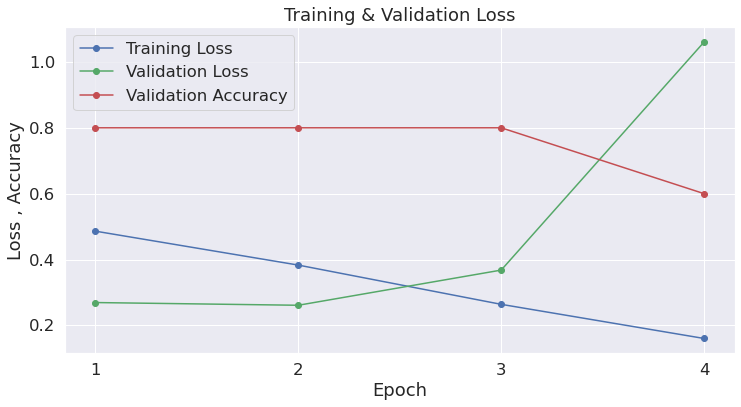

In [13]:

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss , Accuracy")
plt.legend()
plt.xticks(range(1,epochs+1))

plt.show()

In [14]:


###################################################################################
###################################################################################
###################################################################################
###################################################################################
###################################################################################
# update here set sentences and labels = 696 data instead here:
# test file name:  TEST_data_export_2_features.csv
# modified by pierrel

var_WikiText_TEST_clean_df = pd.read_csv('data/WikiLarge_Test.csv')

display(var_WikiText_TEST_clean_df)

var_WikiText_TEST_clean_df['original_text'] = var_WikiText_TEST_clean_df['original_text'].str.lower()
var_WikiText_TEST_clean_df.columns = ['id','text_clean','label']


display(var_WikiText_TEST_clean_df)

#var_WikiText_TEST_df = var_WikiText_TEST_clean_df





#var_WikiText_TEST_clean_df = pd.read_csv('TEST_data_export_2_features.csv')

var_WikiText_TEST_df = var_WikiText_TEST_clean_df[['text_clean']]

sentences = var_WikiText_TEST_df.text_clean.values
#labels = var_WikiText_TEST_df.label.values
var_list_zeros = listofzeros = [0] * len(var_WikiText_TEST_df)
print(len(var_WikiText_TEST_df))
print(len(var_list_zeros))
labels = var_list_zeros

display(var_WikiText_TEST_df)
display()

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(var_WikiText_TEST_df.shape[0]))

###################################################################################
###################################################################################
###################################################################################
###################################################################################
###################################################################################


#  code from Chris McCormick site:
#  source:
#
#  https://mccormickml.com/2019/07/22/BERT-fine-tuning/


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences. (was 64 originally here)
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

,id,original_text,label
0,0,-2011,NaN
1,1,-2011,NaN
2,2,-2000,NaN
3,3,-1997,NaN
4,4,1.636,NaN
...,...,...,...
119087,119087,#NAME?,NaN
119088,119088,#NAME?,NaN
119089,119089,#NAME?,NaN
119090,119090,#NAME?,NaN


,id,text_clean,label
0,0,-2011,NaN
1,1,-2011,NaN
2,2,-2000,NaN
3,3,-1997,NaN
4,4,1.636,NaN
...,...,...,...
119087,119087,#name?,NaN
119088,119088,#name?,NaN
119089,119089,#name?,NaN
119090,119090,#name?,NaN


119092
119092


,text_clean
0,-2011
1,-2011
2,-2000
3,-1997
4,1.636
...,...
119087,#name?
119088,#name?
119089,#name?
119090,#name?


Number of test sentences: 119,092



/home/pierrel/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 119,092 test sentences...
    DONE.


In [16]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)


In [17]:
#### export flat predictions here
print(type(flat_predictions))

###################################################################################
###################################################################################
###################################################################################
###################################################################################
###################################################################################
#   696 - pierrel - umich - update code here to export flat predictions to csv:

var_predictions_696_df = pd.DataFrame(flat_predictions)

var_WikiText_TEST_df['predictions'] = flat_predictions

var_WikiText_TEST_df = var_WikiText_TEST_df.reset_index()

#display(var_WikiText_TEST_df)

var_WikiText_TEST_df_output = var_WikiText_TEST_df[['index','predictions']]
var_WikiText_TEST_df_output.columns = ['id','label']

display(var_WikiText_TEST_df_output)


#  export test dataframe here 
var_WikiText_TEST_df_output.to_csv('TEST_BERT_data_export_4_epochs_BERT_base_100k_tests_Team5.csv', index=False)



#display(var_WikiText_TEST_df_output)

<class 'numpy.ndarray'>


/tmp/ipykernel_3096459/2977212491.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_WikiText_TEST_df['predictions'] = flat_predictions


,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
119087,119087,0
119088,119088,0
119089,119089,0
119090,119090,0


In [18]:
var_WikiText_TEST_df_output['label'].sum()

60872

In [19]:
#### check memory here of objects:
####
#### reference from:  https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('var_WikiText_Train_clean_df', 77031000),
 ('var_WikiText_Train_df', 77031000),
 ('var_WikiText_TEST_clean_df', 22984587),
 ('var_WikiText_TEST_df', 22984587),
 ('var_WikiText_TEST_df_output', 1905616),
 ('var_predictions_696_df', 952880),
 ('flat_predictions', 952848),
 ('flat_true_labels', 952848),
 ('listofzeros', 952792),
 ('var_list_zeros', 952792),
 ('predictions', 33048),
 ('true_labels', 33048),
 ('BertTokenizer', 2008),
 ('params', 1912),
 ('BertForSequenceClassification', 1472),
 ('DataLoader', 1472),
 ('AdamW', 1064),
 ('RandomSampler', 1064),
 ('SequentialSampler', 1064),
 ('TensorDataset', 1064),
 ('BertConfig', 896),
 ('df_stats', 656),
 ('result', 392),
 ('flat_accuracy', 136),
 ('format_time', 136),
 ('get_linear_schedule_with_warmup', 136),
 ('random_split', 136),
 ('logits', 128),
 ('label_ids', 112),
 ('sentences', 112),
 ('training_stats', 88),
 ('attention_masks', 72),
 ('b_input_ids', 72),
 ('b_input_mask', 72),
 ('b_labels', 72),
 ('input_ids', 72),
 ('labels',

In [20]:
var_memory = torch.cuda.mem_get_info()

print("GPU is using = ", (var_memory[0] / var_memory[1])*100, " %")

GPU is using =  63.720602851827934  %


In [21]:
import os
 
# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
 
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

RAM memory % used: 6.3
